# DEPENDENCIES

In [418]:
import openseespy.opensees as ops
import matplotlib.pyplot as plt
import numpy as np


# MODEL CONSTRUCTION

## - INITIALIZATION

In [419]:
ops.wipe()  # Reset OpenSees model
ops.model('basic', '-ndm', 3, '-ndf', 3)  # 3D model with 3 DOF (X, Y, Z translations)

## - NODES CONSTRUCTION

### = Cnfiguration

In [420]:
# -Bridge dimensions
length_span = 8.0  # Length of one span (m)
width_bridge = 6.0  # Width of the bridge (m)
height_pier = 6.0  # Height of the bridge piers (m)
num_span = 4  # Number of spans

In [421]:
# <Helper Variables>
node_id = 1  # Index for node and its initial value
node_list = []  # List to store all nodes
node_deck = []  # List to store all nodes of the bridge deck
node_deck_left = []  # List to store left nodes of the bridge deck
node_deck_right = []  # List to store right nodes of the bridge deck
node_pier = []  # List to store all nodes of the bridge piers
node_pier_left = []  # List to store left nodes of the bridge piers
node_pier_right = []  # List to store right nodes of the bridge piers

### = Create Nodes for the bridge

In [422]:
# - Deck

# Loop over each span to create the nodes for the bridge deck
for i in range(num_span + 1):
    x = i * length_span  # X coordinate based on the span
    ops.node(node_id, x, 0.0, 0.0)  # Left node of the span
    ops.node(node_id + 1, x, width_bridge, 0.0)  # Right node of the span
    node_deck_left.append(node_id)
    node_deck_right.append(node_id + 1)
    node_deck.append(node_id)
    node_deck.append(node_id + 1)
    node_id += 2  # Move to the next

In [423]:
# - Piers

# Loop over each span to create the nodes for the bridge piers
for i in range(1, num_span):
    x = i * length_span  # X coordinate based on the span
    ops.node(node_id, x, 0.0, -height_pier)  # Left node of the span
    ops.node(node_id + 1, x, width_bridge, -height_pier)  # Right node of the span
    node_pier_left.append(node_id)
    node_pier_right.append(node_id + 1)
    node_pier.append(node_id)
    node_pier.append(node_id + 1)
    node_id += 2  # Move to the next

In [424]:
# - Nodes
node_list = node_deck + node_pier

## - MATERIAL CONSTRUCTION

### = Material Properties

In [425]:
# <Material Properties>
E = 12000*10e6  # Elastic modulus for timber (Pa)
A = 0.1   # Cross-sectional area (m^2) 

### = Material Definition

In [426]:
# <Material Definition>
ops.uniaxialMaterial("Elastic", 1, E)

## - ELEMENT CONSTRUCTION

### = Helper Variables

In [427]:
# <Helper Variables>
element_id = 1  # Index for element and its initial value
element_list = []  # List to store all elements
element_deck = []  # List to store all elements of the bridge deck
element_pier = []  # List to store all elements of the bridge piers

### = Create Elements for the Bridge

In [428]:
# <Create Elements (Truss) for the Bridge>

# - Deck Truss Elements

# Loop over each span to create the elements for the bridge deck
for i in range(num_span):
    # Nodes
    left_near_node = node_deck_left[i]
    right_near_node = node_deck_right[i]
    left_far_node = node_deck_left[i + 1]
    right_far_node = node_deck_right[i + 1]
    
    # Y-direction truss elements
    if i == 0:
        ops.element("truss", element_id, left_near_node, right_near_node, A, 1)
        element_deck.append(element_id)
        element_id += 1
    ops.element("truss", element_id, left_far_node, right_far_node, A, 1)
    element_deck.append(element_id)
    element_id += 1
    
    # X-direction truss elements
    ops.element("truss", element_id, left_near_node, left_far_node, A, 1)
    element_deck.append(element_id)
    element_id += 1
    ops.element("truss", element_id, right_near_node, right_far_node, A, 1)
    element_deck.append(element_id)
    element_id += 1
    
    # Diagonal truss elements
    ops.element("truss", element_id, left_near_node, right_far_node, A, 1)
    element_deck.append(element_id)
    element_id += 1 
    ops.element("truss", element_id, left_far_node, right_near_node, A, 1)
    element_deck.append(element_id)
    element_id += 1

# - Pier Truss Elements

# strength reduction factor

# Loop over each span to create the elements for the bridge piers
for i in range(num_span - 1):
    # Nodes
    left_high_node = node_deck_left[i + 1]
    right_high_node = node_deck_right[i + 1]
    left_low_node = node_pier_left[i]
    right_low_node = node_pier_right[i]
    
    if i == 2:
        reduction_factor = 0.9 # modify here to change the reduction factor
    else:
        reduction_factor = 1
    
    
    # Z-direction truss elements
    ops.element("truss", element_id, left_high_node, left_low_node, reduction_factor*2*A, 1)
    element_pier.append(element_id)
    element_id += 1
    ops.element("truss", element_id, right_high_node, right_low_node, reduction_factor*2*A, 1)
    element_pier.append(element_id)
    element_id += 1
    # Diagonal truss elements
    ops.element("truss", element_id, left_high_node, right_low_node, reduction_factor*2*A, 1)
    element_pier.append(element_id)
    element_id += 1
    ops.element("truss", element_id, right_high_node, left_low_node, reduction_factor*2*A, 1)
    element_pier.append(element_id)
    element_id += 1

# - Elements
element_list = element_deck + element_pier

## - MASS CONSTRUCTION

In [429]:
mass_x = 1000
mass_y = 1000
mass_z = 1000

In [430]:
# Set Up Mass for Nodes, assume
for node in node_list:
    ops.mass(node, mass_x, mass_y, mass_z)

## - BOUNDARY CONDITIONS

In [431]:
# [BOUNDARY CONDITIONS]

# 1. Fix the leftmost and rightmost deck nodes in XYZ directions
ops.fix(node_deck_left[0], 1, 1, 1)  # Fix node at left end
ops.fix(node_deck_right[0], 1, 1, 1)  # Fix node at left end
ops.fix(node_deck_left[-1], 0, 1, 1)  # Fix node at right end
ops.fix(node_deck_right[-1], 0, 1, 1)  # Fix node at right end

# 2. Fix all the pier bottom nodes (both left and right)
for i in range(len(node_pier_left)):
    ops.fix(node_pier_left[i], 1, 1, 1)  # Fix left bottom pier nodes
    ops.fix(node_pier_right[i], 1, 1, 1)  # Fix right bottom pier nodes


## - DAMPING CONSTRUCTION

In [432]:
# Modal analysis to obtain the first two modal frequencies (eigenvalues)
eigenvalues = ops.eigen(2)  # Compute the first two eigenvalues
omega1 = np.sqrt(eigenvalues[0])  # First modal frequency (angular)
omega2 = np.sqrt(eigenvalues[1])  # Second modal frequency (angular)

print(f"First Modal Frequency: {omega1:.2f} rad/s")
print(f"Second Modal Frequency: {omega2:.2f} rad/s")

# Damping ratio, assuming a x% damping ratio
xi = 0.05  

# Calculate Rayleigh damping coefficients
alphaM = 2 * xi * omega1 * omega2 / (omega1 + omega2)
betaK = 2 * xi / (omega1 + omega2)

# Add Rayleigh damping to the model
ops.rayleigh(alphaM, betaK, 0.0, 0.0)


First Modal Frequency: 504.15 rad/s
Second Modal Frequency: 968.55 rad/s


## - MODEL VISUALIZATION

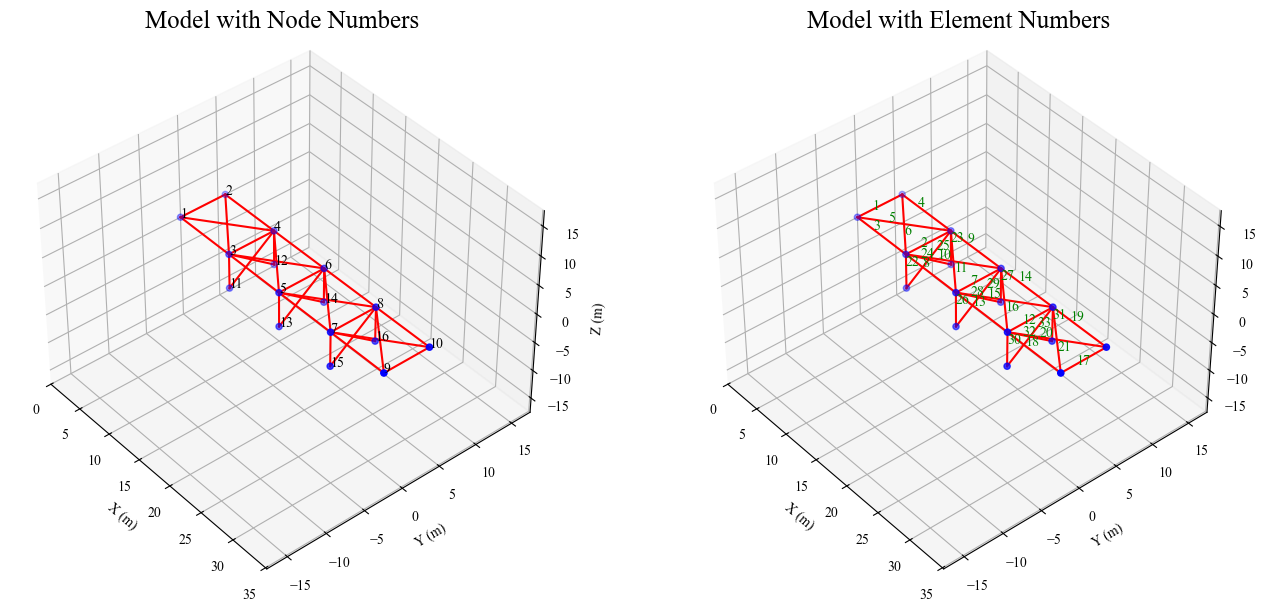

In [433]:
# Function to extract coordinates of nodes
def get_node_coords(node_ids):
    x_coords = [ops.nodeCoord(node_id)[0] for node_id in node_ids]
    y_coords = [ops.nodeCoord(node_id)[1] for node_id in node_ids]
    z_coords = [ops.nodeCoord(node_id)[2] for node_id in node_ids]
    return x_coords, y_coords, z_coords

# Setting Times New Roman font for the entire plot
plt.rcParams["font.family"] = "Times New Roman"

# Plotting the model with node numbers and element numbers
fig = plt.figure(figsize=(14, 6))

# Define axis limits to be uniform and "clean" (rounded values)
x_lim = [0, length_span * num_span*1.1]
y_lim = [-width_bridge*1.1, width_bridge*1.1]
z_lim = [-height_pier*1.1, height_pier*1.1]

# Set the viewing angle to be consistent for both plots
view_elev = 40  # Elevation angle
view_azim = -40  # Azimuth angle

# Function to set equal aspect ratio for 3D plots
def set_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max([x_range, y_range, z_range])

    x_middle = np.mean(x_limits)
    y_middle = np.mean(y_limits)
    z_middle = np.mean(z_limits)

    ax.set_xlim3d([x_middle - max_range / 2, x_middle + max_range / 2])
    ax.set_ylim3d([y_middle - max_range / 2, y_middle + max_range / 2])
    ax.set_zlim3d([z_middle - max_range / 2, z_middle + max_range / 2])

# Left plot: Model with node numbers
ax1 = fig.add_subplot(121, projection='3d')
x_coords, y_coords, z_coords = get_node_coords(node_list)
ax1.scatter(x_coords, y_coords, z_coords, c='b', marker='o', label='Nodes')

# Add node labels
for node_id in node_list:
    x, y, z = ops.nodeCoord(node_id)
    ax1.text(x, y, z, f'{node_id}', fontsize=10, color='black')  # Node number

# Plot the elements (lines connecting nodes)
for elem_id in element_list:
    nodes = ops.eleNodes(elem_id)
    x_elem, y_elem, z_elem = get_node_coords(nodes)
    ax1.plot(x_elem, y_elem, z_elem, 'r-')  # Red lines for elements

# Set axis limits and the viewing angle
ax1.set_xlim(x_lim)
ax1.set_ylim(y_lim)
ax1.set_zlim(z_lim)
ax1.view_init(elev=view_elev, azim=view_azim)

# Set equal aspect ratio
set_axes_equal(ax1)

# Axis labels and title with increased font size for title
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_zlabel('Z (m)')
ax1.set_title('Model with Node Numbers', fontsize=18)

# Right plot: Model with element numbers
ax2 = fig.add_subplot(122, projection='3d')

# Plot the nodes again
ax2.scatter(x_coords, y_coords, z_coords, c='b', marker='o', label='Nodes')

# Add element labels at 1/3 length of each element
for elem_id in element_list:
    nodes = ops.eleNodes(elem_id)
    x_elem, y_elem, z_elem = get_node_coords(nodes)
    ax2.plot(x_elem, y_elem, z_elem, 'r-')  # Red lines for elements
    
    # Calculate the 1/3 position of each element for label
    third_x_elem = x_elem[0] + (x_elem[1] - x_elem[0]) * 0.33
    third_y_elem = y_elem[0] + (y_elem[1] - y_elem[0]) * 0.33
    third_z_elem = z_elem[0] + (z_elem[1] - z_elem[0]) * 0.33
    ax2.text(third_x_elem, third_y_elem, third_z_elem, f'{elem_id}', fontsize=10, color='green')  # Element number at 1/3 length

# Set axis limits and the viewing angle
ax2.set_xlim(x_lim)
ax2.set_ylim(y_lim)
ax2.set_zlim(z_lim)
ax2.view_init(elev=view_elev, azim=view_azim)

# Set equal aspect ratio
set_axes_equal(ax2)

# Axis labels and title with increased font size for title
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_zlabel('Z (m)')
ax2.set_title('Model with Element Numbers', fontsize=18)

plt.tight_layout()

# save the picture
plt.savefig('model.png', dpi=300)

plt.show()



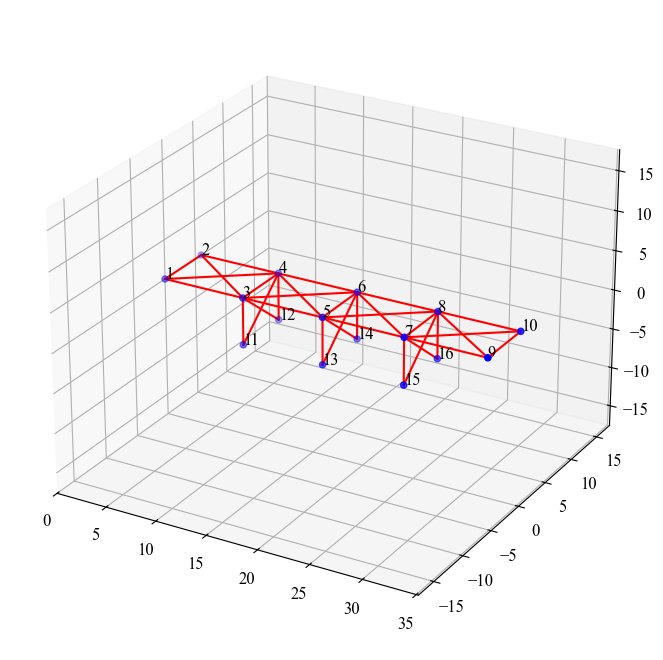

In [434]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to extract coordinates of nodes
def get_node_coords(node_ids):
    x_coords = [ops.nodeCoord(node_id)[0] for node_id in node_ids]
    y_coords = [ops.nodeCoord(node_id)[1] for node_id in node_ids]
    z_coords = [ops.nodeCoord(node_id)[2] for node_id in node_ids]
    return x_coords, y_coords, z_coords

# Setting Times New Roman font for the entire plot
plt.rcParams["font.family"] = "Times New Roman"

# Plotting the model with node numbers
fig = plt.figure(figsize=(10, 8))

# Define axis limits to be uniform and "clean" (rounded values)
x_lim = [0, length_span * num_span * 1.1]
y_lim = [-width_bridge * 1.1, width_bridge * 1.1]
z_lim = [-height_pier * 1.1, height_pier * 1.1]

# Set the viewing angle
view_elev = 25  # Elevation angle
view_azim = -60  # Azimuth angle

# Function to set equal aspect ratio for 3D plots
def set_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    y_range = abs(y_limits[1] - y_limits[0])
    z_range = abs(z_limits[1] - z_limits[0])

    max_range = max([x_range, y_range, z_range])

    x_middle = np.mean(x_limits)
    y_middle = np.mean(y_limits)
    z_middle = np.mean(z_limits)

    ax.set_xlim3d([x_middle - max_range / 2, x_middle + max_range / 2])
    ax.set_ylim3d([y_middle - max_range / 2, y_middle + max_range / 2])
    ax.set_zlim3d([z_middle - max_range / 2, z_middle + max_range / 2])

# Plot: Model with node numbers
ax = fig.add_subplot(111, projection='3d')
x_coords, y_coords, z_coords = get_node_coords(node_list)
ax.scatter(x_coords, y_coords, z_coords, c='b', marker='o', label='Nodes')

# Add node labels
for node_id in node_list:
    x, y, z = ops.nodeCoord(node_id)
    ax.text(x, y, z, f'{node_id}', fontsize=12, color='black')  # Enlarged node number labels

# Plot the elements (lines connecting nodes)
for elem_id in element_list:
    nodes = ops.eleNodes(elem_id)
    x_elem, y_elem, z_elem = get_node_coords(nodes)
    ax.plot(x_elem, y_elem, z_elem, 'r-')  # Red lines for elements

# Set axis limits and the viewing angle
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)
ax.set_zlim(z_lim)
ax.view_init(elev=view_elev, azim=view_azim)

# Set equal aspect ratio
set_axes_equal(ax)

# Axis labels and title with increased font size for title and tick labels
# ax.set_xlabel('X (m)', fontsize=14, labelpad=15)
# ax.set_ylabel('Y (m)', fontsize=14, labelpad=15)
# ax.set_zlabel('Z (m)', fontsize=14, labelpad=15)
# ax.set_title('Truss Bridge Model', fontsize=16, pad=20)

# Enlarging tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust layout to make sure all content fits within the figure boundaries
plt.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.1)

# Save the picture
plt.savefig('truss_bridge_model.png', dpi=300, bbox_inches='tight')

plt.show()


# LOAD APPLICATION

In [435]:
# Apply random white noise dynamic load to nodes 5
dt = 0.01  # Time step in seconds
time_steps = 1000  # Number of time steps
time = np.linspace(0, dt * time_steps, time_steps)

# Generate white noise excitation for nodes 3 and 8
white_noise = np.random.normal(0, 1, time_steps)*10000

# Apply white noise to node 3 (left side of the second span)
ops.timeSeries('Path', 1, '-dt', dt, '-values', *white_noise)
ops.pattern('Plain', 1, 1)

# ops.load(5, 0.3, 0.05, 0.8)  # Apply white noise in Z direction
for node in node_deck:
    ops.load(node, 0.2 * np.random.normal(0, 1), 0.0, 1 * np.random.normal(0, 1))

# Define gravity
g = 9.81  # m/s^2, gravitational acceleration

# Apply gravity to all nodes in the Z direction
for node in node_list:

    # Compute gravity force in Z direction: F_z = mass_z * g
    gravity_force_z = mass_z * g
    
    # Apply the gravity load to the node in Z direction
    ops.load(node, 0.0, 0.0, -gravity_force_z)  # X, Y, Z components


# ANALYSES & RECORDING

In [436]:
# Recorder for nodes 3 and 8 displacements
ops.recorder('Node', '-file', 'disp_node_3.txt', '-time', '-node', 3, '-dof', 1, 2, 3, 'disp')
ops.recorder('Node', '-file', 'disp_node_8.txt', '-time', '-node', 8, '-dof', 1, 2, 3, 'disp')

# Define analysis options
ops.algorithm('Newton')
ops.system('BandGeneral')
ops.numberer('Plain')
ops.constraints('Plain')
ops.integrator('Newmark', 0.5, 0.25)
ops.analysis('Transient')

# Run analysis
ops.analyze(time_steps, dt)

0

# POST-PROCESSING

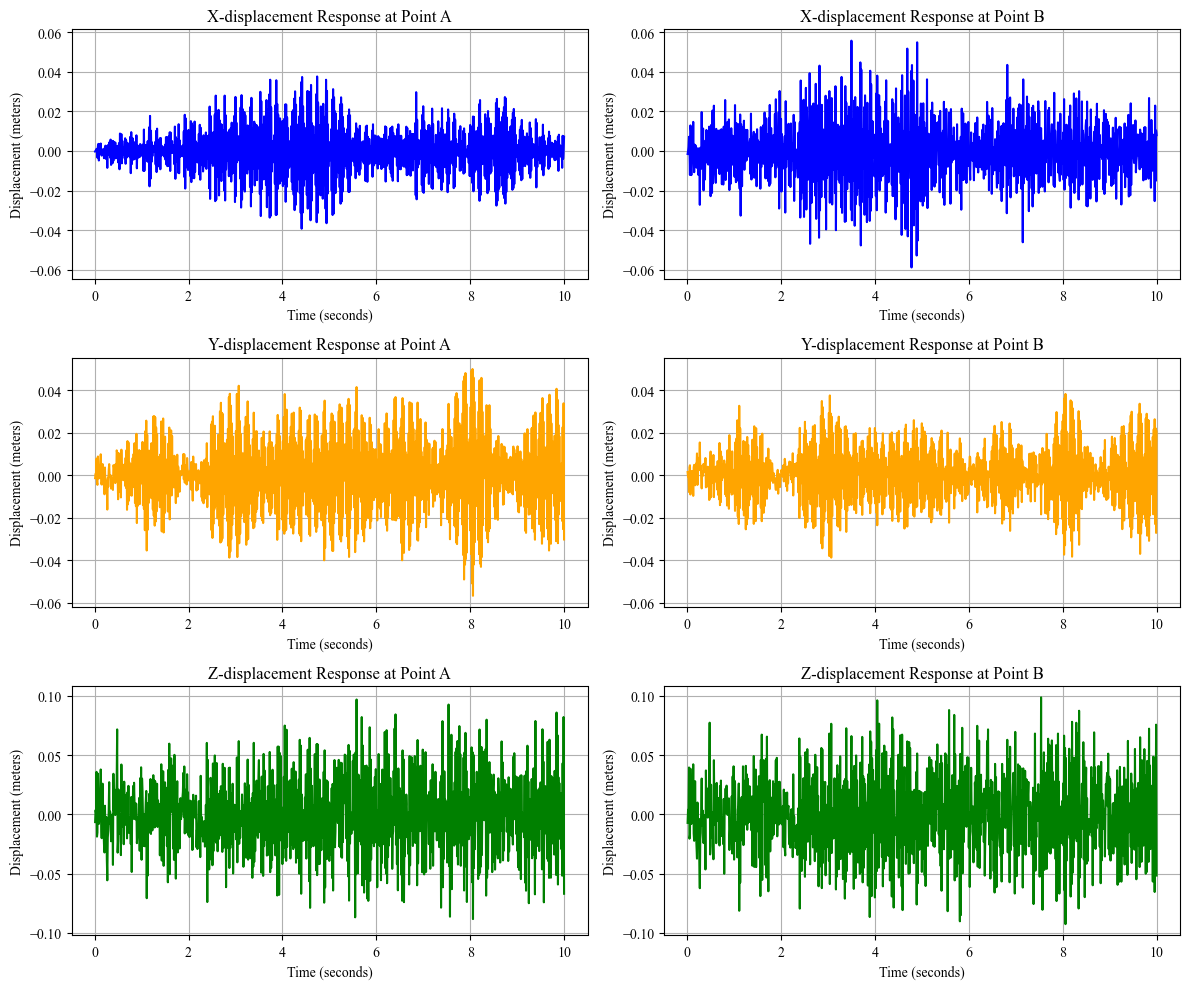

In [437]:
# Load the recorded displacements
point_A = np.loadtxt('disp_node_3.txt')
point_B = np.loadtxt('disp_node_8.txt')

# Create a figure for side-by-side comparison
plt.figure(figsize=(12, 10))

# Find global x (time) limits for all plots and add padding (5%)
time_min = min(point_A[:, 0].min(), point_B[:, 0].min())
time_max = max(point_A[:, 0].max(), point_B[:, 0].max())
time_padding = (time_max - time_min) * 0.05
time_min -= time_padding
time_max += time_padding

# Plot the X, Y, Z displacement results for point A and point B

# X-displacement
x_min = min(point_A[:, 1].min(), point_B[:, 1].min())
x_max = max(point_A[:, 1].max(), point_B[:, 1].max())
x_padding = (x_max - x_min) * 0.05
x_min -= x_padding
x_max += x_padding

plt.subplot(3, 2, 1)
plt.plot(point_A[:, 0], point_A[:, 1], label='Point A X-displacement', color='blue')
plt.xlabel('Time (seconds)')
plt.ylabel('Displacement (meters)')
plt.title('X-displacement Response at Point A')
plt.xlim(time_min, time_max)
plt.ylim(x_min, x_max)
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot(point_B[:, 0], point_B[:, 1], label='Point B X-displacement', color='blue')
plt.xlabel('Time (seconds)')
plt.ylabel('Displacement (meters)')
plt.title('X-displacement Response at Point B')
plt.xlim(time_min, time_max)
plt.ylim(x_min, x_max)
plt.grid(True)

# Y-displacement
y_min = min(point_A[:, 2].min(), point_B[:, 2].min())
y_max = max(point_A[:, 2].max(), point_B[:, 2].max())
y_padding = (y_max - y_min) * 0.05
y_min -= y_padding
y_max += y_padding

plt.subplot(3, 2, 3)
plt.plot(point_A[:, 0], point_A[:, 2], label='Point A Y-displacement', color='orange')
plt.xlabel('Time (seconds)')
plt.ylabel('Displacement (meters)')
plt.title('Y-displacement Response at Point A')
plt.xlim(time_min, time_max)
plt.ylim(y_min, y_max)
plt.grid(True)

plt.subplot(3, 2, 4)
plt.plot(point_B[:, 0], point_B[:, 2], label='Point B Y-displacement', color='orange')
plt.xlabel('Time (seconds)')
plt.ylabel('Displacement (meters)')
plt.title('Y-displacement Response at Point B')
plt.xlim(time_min, time_max)
plt.ylim(y_min, y_max)
plt.grid(True)

# Z-displacement
z_min = min(point_A[:, 3].min(), point_B[:, 3].min())
z_max = max(point_A[:, 3].max(), point_B[:, 3].max())
z_padding = (z_max - z_min) * 0.05
z_min -= z_padding
z_max += z_padding

plt.subplot(3, 2, 5)
plt.plot(point_A[:, 0], point_A[:, 3], label='Point A Z-displacement', color='green')
plt.xlabel('Time (seconds)')
plt.ylabel('Displacement (meters)')
plt.title('Z-displacement Response at Point A')
plt.xlim(time_min, time_max)
plt.ylim(z_min, z_max)
plt.grid(True)

plt.subplot(3, 2, 6)
plt.plot(point_B[:, 0], point_B[:, 3], label='Point B Z-displacement', color='green')
plt.xlabel('Time (seconds)')
plt.ylabel('Displacement (meters)')
plt.title('Z-displacement Response at Point B')
plt.xlim(time_min, time_max)
plt.ylim(z_min, z_max)
plt.grid(True)

plt.tight_layout()
plt.show()


In [438]:
ops.wipe()

In [439]:
# Compare the maximum values of the displacements along x, y, z directions for two monitoring points

# X displacement comparison
max_disp_x_point_A = np.max(np.abs(point_A[:, 1]))
max_disp_x_point_B = np.max(np.abs(point_B[:, 1]))
print(f'Maximum X-displacement at Point A: {max_disp_x_point_A:.8f} meters')
print(f'Maximum X-displacement at Point B: {max_disp_x_point_B:.8f} meters')

# Y displacement comparison
max_disp_y_point_A = np.max(np.abs(point_A[:, 2]))
max_disp_y_point_B = np.max(np.abs(point_B[:, 2]))
print(f'Maximum Y-displacement at Point A: {max_disp_y_point_A:.8f} meters')
print(f'Maximum Y-displacement at Point B: {max_disp_y_point_B:.8f} meters')

# Z displacement comparison
max_disp_z_point_A = np.max(np.abs(point_A[:, 3]))
max_disp_z_point_B = np.max(np.abs(point_B[:, 3]))
print(f'Maximum Z-displacement at Point A: {max_disp_z_point_A:.8f} meters')
print(f'Maximum Z-displacement at Point B: {max_disp_z_point_B:.8f} meters')

Maximum X-displacement at Point A: 0.03923730 meters
Maximum X-displacement at Point B: 0.05877450 meters
Maximum Y-displacement at Point A: 0.05671820 meters
Maximum Y-displacement at Point B: 0.03877320 meters
Maximum Z-displacement at Point A: 0.09703430 meters
Maximum Z-displacement at Point B: 0.09885170 meters


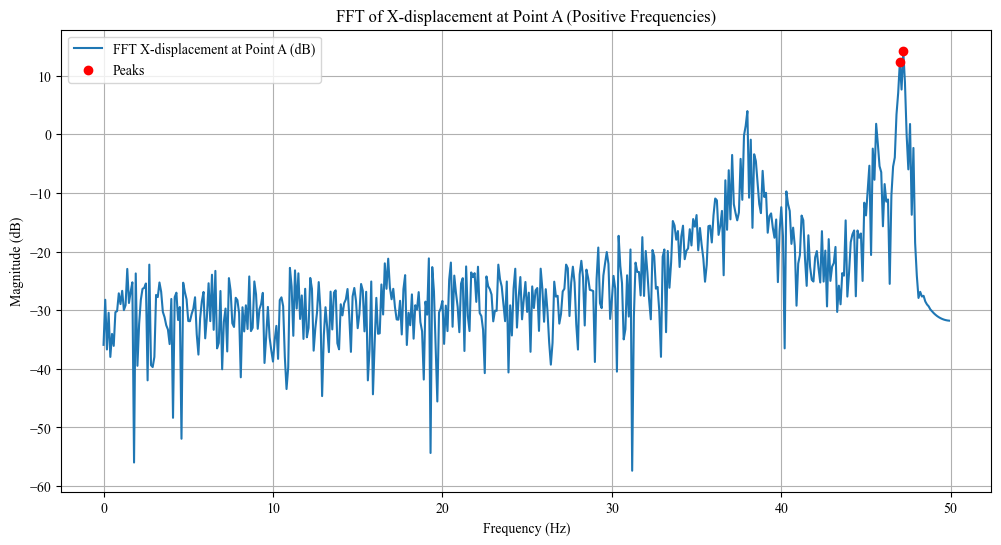

In [440]:
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

# Compute the Fourier Transform of the displacement data (point_A should be your displacement data)
fft_x_point_A = fft(point_A[:, 1])

# Compute the number of samples
n = len(point_A[:, 0])

# Compute the sampling frequency
sampling_freq = 1 / dt  # Hz

# Compute the FFT frequency values
fft_freq = fftfreq(n, d=1/sampling_freq)

# Select only the positive half of the frequency axis
positive_freq = fft_freq[:n//2]
positive_fft_x_point_A = fft_x_point_A[:n//2]

# Convert magnitude to decibels (dB)
magnitude_db = 20 * np.log10(np.abs(positive_fft_x_point_A))

# Find the peaks in the FFT data
peaks, _ = find_peaks(magnitude_db, height=10)  # Adjust the height threshold as needed

# Plot the FFT results (in dB)
plt.figure(figsize=(12, 6))
plt.plot(positive_freq, magnitude_db, label='FFT X-displacement at Point A (dB)')
plt.plot(positive_freq[peaks], magnitude_db[peaks], 'ro', label='Peaks')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.title('FFT of X-displacement at Point A (Positive Frequencies)')
plt.legend()
plt.grid(True)
plt.show()
